In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from glob import glob
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

In [2]:
def load_data(file, sheet_name):
    return pd.read_excel(file, sheet_name=sheet_name)

In [3]:
def load_all_data():
    files = glob('/Users/sabin/Documents/Project/뉴스와 소셜데이터 기반 이슈 분석 및 시각화/Trend-analysis/dataset/임대차3법(54,752건)/*.xlsx')
    df = pd.DataFrame()
    for file in files:
        df = df.append(load_data(file, '뉴스'))
    return df

news = load_all_data()

## 뉴스 Sheet

In [4]:
news.isna().sum()

Unnamed: 0     0
Unnamed: 1     0
Unnamed: 2     0
Unnamed: 3    15
dtype: int64

In [5]:
news.columns = news.iloc[0]
news.drop(0, inplace=True, axis=0)
news = news.dropna(axis=0, how='any')
news = news[~news['내용'].str.contains('http')]
news = news[news['내용'].str.contains('[가-힣]')]
news = news[news['내용'].str.len() < 1000]

print(news.shape)
news.head()

(3999, 4)


,작성일,작성자,제목,내용
36,2020/07/29,한국경제,"은성수 ""임대차 3법 때문에 가계부채 급증 없을 것""",국회 정무위원회 업무보고 답변 은성수 금융위원장이 29일 오전 서울 여의도 국회에서...
46,2020/11/09,한국경제TV,"""전세대란, 임대차3법도 영향"" 홍남기는 뒤늦게 인정했지만...",[한국경제TV 조현석 기자] 홍남기 경제부총리 겸 기획재정부 장관이 임대차3법이 최...
49,2020/09/28,조선비즈,"시민단체, 임대차3법 헌법소원… “늘어난 것 정부 세수뿐”",28일 서울 종로구 헌법재판소 앞에서 임대차3법 반대모임과 행동하는 자유시민 관계자...
50,2020/09/25,조선비즈,"""임대차 3법, 명백한 재산침해"" 시민단체, 헌법소원 제기",주택 임대차 보장기간을 최대 4년으로 늘리는 내용을 골자로 한 임대차3법(주택임대차...
99,2020/07/29,뉴스1,"은성수 ""임대차 3법으로 가계부채 급증하지는 않을 것""",국회 정무위원회 전체회의 은성수 금융위원장이 29일 오전 서울 여의도 국회에서 열린...


In [6]:
def tfdif(corpus):
    cv = CountVectorizer(ngram_range=(1, 2), max_features=1000)
    document_term_matrix = cv.fit_transform(corpus)

    tf = pd.DataFrame(document_term_matrix.toarray(), columns=cv.get_feature_names())  # TF (Term Frequency)

    D = len(tf)
    df = tf.astype(bool).sum(axis=0)
    idf = np.log((D+1) / (df+1)) + 1             # IDF (Inverse Document Frequency)

    # TF-IDF (Term Frequency-Inverse Document Frequency)
    tfidf = tf * idf                      
    tfidf = tfidf / np.linalg.norm(tfidf, axis=1, keepdims=True)
    
    return tfidf


## Key phrase
* ngram_range=(2,5)

In [7]:
def get_tfidf(ngram_range=(2,5), max_features=1000):
    vocab = {}
    tfidf = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    
    for content in news['내용']:
        if len(content) < 500:
            continue
        new_tfidf = tfidf.fit_transform(content.split(','))
        new_tfidf = new_tfidf.toarray()
        new_tfidf = pd.DataFrame(new_tfidf, columns=tfidf.get_feature_names())
        new_tfidf = new_tfidf.sum(axis=0).sort_values(ascending=False)[:10]
        for key, value in new_tfidf.items():
            if key in vocab:
                vocab[key] += value
            else:
                vocab[key] = value
        
    return vocab

In [8]:
vocab = get_tfidf(ngram_range=(2,4))

In [9]:
vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

In [10]:
vocab[11:30]

[('전월세 상한제', 11.119977814615662),
 ('서울 아파트', 10.158680230228054),
 ('실수요자 보호', 10.0),
 ('타협의 정치', 10.0),
 ('김현미 국토교통부', 8.838545486503511),
 ('동영상 뉴스', 8.679415698096058),
 ('월세 상한제', 8.48665896270393),
 ('김상조 청와대', 6.682336957429225),
 ('한국토지주택공사 lh', 6.608931442204987),
 ('한국개발연구원 kdi', 6.288675134594813),
 ('국회에서 열린', 6.22693130779695),
 ('주택공급을 확대하며', 6.0),
 ('대출 규제', 6.0),
 ('부동산 정책', 5.481589122524672),
 ('월세 신고제', 5.19212218794031),
 ('yna co', 5.1267175906147955),
 ('가격 움직임', 5.0),
 ('yna co kr', 4.864570009715203),
 ('국토교통부 장관', 4.77551335208706)]

In [11]:
with open('tfdif_뉴스_vocab_keyphrase.json', 'w') as f:
    json.dump(vocab[11:], f)

(-0.5, 799.5, 599.5, -0.5)

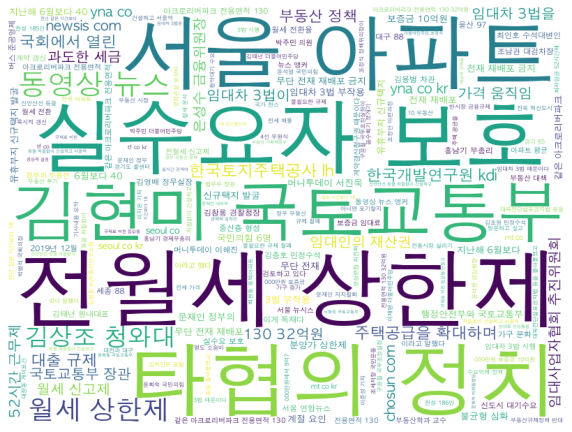

In [12]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(vocab[11:]))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [13]:
wordcloud.to_file('tfidf_뉴스_wordcloud_keyphrase.png')

## Key Word

In [14]:
keyword = get_tfidf(ngram_range=(1,2))
keyword = sorted(keyword.items(), key=lambda x: x[1], reverse=True)
keyword

[('임대차', 207.61877336910462),
 ('부동산', 188.49384965712335),
 ('있다', 95.06935867290079),
 ('월세', 92.38523653710013),
 ('전세', 85.44003961228222),
 ('서울', 83.93840164168057),
 ('무단전재', 83.11879855882096),
 ('금지', 80.15960975834152),
 ('기자', 69.92852877597345),
 ('재배포', 66.12569638385911),
 ('재배포 금지', 64.91022013140278),
 ('무단전재 재배포', 63.78943025924098),
 ('의원은', 62.50953455107273),
 ('3법', 59.747324359247),
 ('임대차 3법', 56.91152132851368),
 ('아파트', 51.35754284045267),
 ('전월세', 47.986700988540214),
 ('이라고', 43.65598981494335),
 ('국민의힘', 39.899584706986175),
 ('국회', 33.97243643534358),
 ('것으로', 33.36385187070197),
 ('했다', 32.09723930772958),
 ('말했다', 31.970773681011078),
 ('주택', 31.031839433228754),
 ('정부', 30.12334680277419),
 ('장관은', 30.03015982236186),
 ('보증금', 28.695111240577017),
 ('문재인', 27.37827426500663),
 ('카카오톡', 27.3439770659695),
 ('tv조선제보', 27.135462651912427),
 ('카카오톡 tv조선제보', 27.135462651912427),
 ('있습니다', 25.597519411227847),
 ('더불어민주당', 24.317486661752486),
 ('변형', 24.0),
 (

In [15]:
with open('tfdif_뉴스_keyword.json', 'w') as f:
    json.dump(keyword, f)

(-0.5, 799.5, 599.5, -0.5)

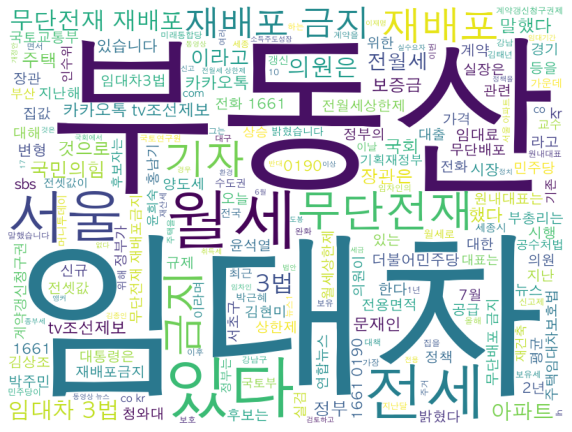

In [16]:
wordcloud = WordCloud(background_color='white', width=800, height=600, font_path='/Library/Fonts/AppleGothic.ttf').generate_from_frequencies(dict(keyword))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis('off')

In [17]:
wordcloud.to_file('tfidf_뉴스_wordcloud_keyword.png')

# TFDIF

We couldn't figure the relationship between the words linearly

as we can see in the graph above